In [31]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
from nltk.stem import SnowballStemmer
nltk.download('punkt')
stemmer = SnowballStemmer('portuguese')
import re
from unidecode import unidecode
from keras.regularizers import l2
from gensim.models import KeyedVectors
from tensorflow.keras import layers
from tensorflow.keras.losses import categorical_crossentropy
from keras.layers import Dense, Dropout, LSTM

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/augusto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/augusto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Pipeline 

In [32]:
# Base original da B2W, sem cortes + clean de overall_rating
b2wCorpus = pd.read_csv("B2W-Reviews01.csv",";",usecols=['review_text','overall_rating'])

# Filtro
d = b2wCorpus.index[b2wCorpus["overall_rating"] < 1].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])
d = b2wCorpus.index[b2wCorpus["overall_rating"] > 5].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])
#d = b2wCorpus.index[b2wCorpus["overall_rating"] == 2].tolist()
#b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])
#b2wCorpus['overall_rating'].replace({5: 2}, inplace = True)
#print(b2wCorpus.head)

In [33]:
SEQUENCE_MAXLEN = 40

# Cleanning function
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
  text = unidecode(text)
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  text = re.sub("\d+", "", text)
  text = re.sub(r'(?:^| )\w(?:$| )', ' ', text).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [34]:
# Cleanning exec
b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: preprocess(x))

In [35]:
print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    4  contente compra entrega rapida unico problema ...
1                    4        apenas consegui comprar lindo copo acrilico
2                    4  supera agilidade praticidade outras panelas el...
3                    4          filho amou parece verdade tantos detalhes
4                    5  entrega prazo americanas estao parabens smart ...
...                ...                                                ...
132368               5  vale usando controle xbox durou semana carga p...
132369               5  pratico barato super indico produto corre dia ...
132370               4    chegou antes prazo previsto corresponde anuncio
132371               1  material fraco poderia ser melhor ficou devend...
132372               1  comprei produto chegou avaria devolvi ja vai f...

[132373 rows x 2 columns]>


In [36]:
b2wCorpus.overall_rating .value_counts().sort_index()

1    27369
2     8389
3    16315
4    32345
5    47955
Name: overall_rating, dtype: int64

In [37]:
# Partilha
b2wCorpus = b2wCorpus.sample(frac=1).reset_index(drop=True)
print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    1  pessimo nao esquenta chapinha fecha direito jo...
1                    4  ja site otimo aparelho porem alto falante vem ...
2                    5  excelente produto caixa lacrada todos acessori...
3                    1  bom dia site oficial espetos mostram espeto pi...
4                    5  gente quer ver milagre cabelo ressecado precis...
...                ...                                                ...
132368               1  so queria ter recebido produto ne paguei fiz t...
132369               5                bom atendeu totalmente necessidades
132370               5  produto qualidade adequado pratica atividades ...
132371               5  medicamento combate tres potenciais problemas ...
132372               3                serviu bem proposto recomendo todos

[132373 rows x 2 columns]>


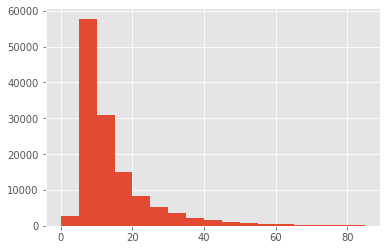

131993


In [38]:
# histograma de palavras x qtd de linhas
Words = [len(linha.split()) for linha in b2wCorpus["review_text"] if len(linha.split()) <=100 ]
plt.style.use('ggplot')
plt.hist(Words, bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85])
plt.show()
print(len(Words))

In [39]:
# Codifica
N =  200001
with open("cbow_s50.txt", "r",encoding='utf-8') as file:
    head = [next(file) for x in range(N)]

head[0] = str(N-1)+ " " + "50"+ "\n" # Conserta contagem de palavras
with open("word2vec_200k.txt", "w",encoding='utf-8') as file:
    for line in head:
        file.write(line)

def vocaIndex(lista, stem=False):
    for indice in range(len(lista)):
        text=lista[indice].lower()
        if text in model.vocab:
             lista[indice] = model.vocab[text].index
        else: 
             lista[indice] = '199999'
    return lista

model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')

def codifica(text, stem=False):
    tokens = nltk.word_tokenize(text)
    tokens = vocaIndex(tokens)
    return tokens

b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: codifica(x))

In [40]:
b2wCorpus['ord'] = b2wCorpus.apply(lambda row: len(row.review_text), axis=1)

In [41]:
b2wCorpus.shape

(132373, 3)

In [42]:
#b2wCorpus = b2wCorpus[b2wCorpus.ord != 0]
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord < 10].index)
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord > SEQUENCE_MAXLEN].index)

In [43]:
b2wCorpus['overall_rating'] = b2wCorpus.overall_rating.apply(lambda x: x - 1)

In [44]:
b2wCorpus.shape

(65887, 3)

In [45]:
b2wCorpus.reset_index(drop=True, inplace=True)

In [46]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,3,"[12783, 1229, 101071, 3006, 17382, 718, 23199,...",30
1,4,"[2104, 902, 1446, 82077, 88, 199999, 2499, 477...",10
2,0,"[226, 86, 1229, 513, 81299, 3174, 45929, 14680...",24
3,4,"[477, 185, 215, 7119, 2951, 156721, 631, 2399,...",22
4,2,"[36296, 199999, 902, 226, 271, 86, 86, 2104, 1...",12


In [47]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [48]:
#b2wCorpus.review_text.str.rjust(width=50, fillchar='0')
#np.reshape(y_train,(-1))

b2wCorpus.review_text = keras.preprocessing.sequence.pad_sequences(b2wCorpus.apply(lambda row: np.reshape(row.review_text,(-1)), axis=1), maxlen=SEQUENCE_MAXLEN, padding='post').tolist()

In [49]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,3,"[12783, 1229, 101071, 3006, 17382, 718, 23199,...",30
1,4,"[2104, 902, 1446, 82077, 88, 199999, 2499, 477...",10
2,0,"[226, 86, 1229, 513, 81299, 3174, 45929, 14680...",24
3,4,"[477, 185, 215, 7119, 2951, 156721, 631, 2399,...",22
4,2,"[36296, 199999, 902, 226, 271, 86, 86, 2104, 1...",12


In [50]:
# Função de split
def train_validate_test_split(df, train_percent=.65, validate_percent=.1, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [51]:
b2wCorpusTrain, b2wCorpusValidate, b2wCorpusTest = train_validate_test_split(b2wCorpus)

In [52]:
b2wCorpusTrain=b2wCorpusTrain.reindex(b2wCorpusTrain['ord'].sort_values(ascending=False).index)
b2wCorpusTrain.head()

,overall_rating,review_text,ord
30185,2,"[26416, 363, 3929, 10015, 2583, 90585, 17382, ...",40
56544,0,"[902, 62, 7804, 428, 20252, 935, 5460, 199999,...",40
20410,0,"[9735, 902, 428, 19181, 86, 31116, 6468, 3147,...",40
24923,4,"[408, 486, 1645, 10428, 9735, 86, 141, 86, 199...",40
42343,0,"[199999, 2197, 3656, 29604, 1643, 1664, 42998,...",40


In [53]:
b2wCorpusValidate=b2wCorpusValidate.reindex(b2wCorpusValidate['ord'].sort_values(ascending=False).index)
b2wCorpusValidate.head

<bound method NDFrame.head of        overall_rating                                        review_text  ord
40756               0  [7256, 6689, 193, 104, 166780, 9735, 2689, 543...   40
61781               2  [305, 7804, 532, 714, 902, 3547, 1879, 20253, ...   40
60852               0  [199999, 1664, 86, 578, 2499, 86, 7804, 3013, ...   40
14309               0  [902, 199999, 1118, 372, 481, 188512, 12956, 3...   40
53138               3  [10410, 23933, 5841, 8474, 1188, 18858, 199999...   40
...               ...                                                ...  ...
53527               4  [902, 161274, 532, 199999, 3590, 428, 70, 6163...   10
1223                3  [1893, 7431, 3615, 19634, 2499, 2789, 85324, 1...   10
21872               4  [462, 981, 2789, 3330, 63936, 199999, 428, 131...   10
22970               1  [902, 226, 10813, 7804, 6376, 12572, 2224, 171...   10
19202               0  [1643, 1664, 3780, 29648, 18874, 141, 62, 7804...   10

[6588 rows x 3 columns]>

In [54]:
b2wCorpusTest=b2wCorpusTest.reindex(b2wCorpusTest['ord'].sort_values(ascending=False).index)
b2wCorpusTest.head

<bound method NDFrame.head of        overall_rating                                        review_text  ord
31921               2  [74645, 226, 226, 26956, 70, 199999, 17382, 11...   40
33894               3  [2104, 79777, 3193, 199999, 70, 2942, 201, 147...   40
49252               3  [7804, 1110, 99586, 2832, 4610, 532, 978, 178,...   40
5492                0  [1643, 600, 25999, 50697, 8653, 31182, 1101, 5...   40
16997               1  [902, 226, 363, 532, 17382, 15509, 930, 20096,...   40
...               ...                                                ...  ...
7903                4  [199999, 902, 2104, 2499, 199999, 428, 70, 131...   10
1764                4  [428, 131, 566, 4853, 2789, 22522, 428, 122, 4...   10
58828               4  [1721, 16808, 138589, 1494, 110, 5841, 3553, 6...   10
56985               3  [23904, 2694, 4773, 101236, 2216, 11759, 3690,...   10
39683               4  [6376, 935, 22522, 37822, 199999, 345, 958, 66...   10

[16473 rows x 3 columns]>

In [55]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [56]:
# Treino, Validação e teste
RANDOM_SEED = 42
x_train =  [ emb for emb in b2wCorpusTrain.review_text]
y_train =   b2wCorpusTrain.overall_rating
x_val = [ emb for emb in b2wCorpusValidate.review_text ]
y_val = b2wCorpusValidate.overall_rating
x_train = np.asarray(x_train)
x_val =np.asarray(x_val)

np.random.seed(RANDOM_SEED)
model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')
emb = model.get_keras_embedding()
#emb.trainable = True

In [57]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
model = keras.Sequential()
model.add(layers.Input(shape=(SEQUENCE_MAXLEN, )))
model.add(emb)
model.add(keras.layers.LSTM(128, dropout=0.5))
#model.add(Dropout(0.50))
model.add(keras.layers.Dense(5, activation='softmax'))
#opt = tf.keras.optimizers.SGD(learning_rate=.1, momentum=.5)
#opt = tf.keras.optimizers.Adamax(learning_rate=0.01, beta_1=.9, beta_2=.9, epsilon=1e-07, name="Adamax")
#model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['acc', 'mae'])
opt="adam"
model.compile(optimizer=opt,loss=sparse_categorical_crossentropy, metrics=["accuracy"])
history = model.fit(
    x= x_train, y=y_train, batch_size=16, epochs=50, validation_data=(x_val, y_val))


Epoch 1/50
2677/2677 [==============================] - 50s 19ms/step - loss: 1.3060 - accuracy: 0.4758 - val_loss: 1.1886 - val_accuracy: 0.5258
Epoch 2/50
2677/2677 [==============================] - 50s 19ms/step - loss: 1.2045 - accuracy: 0.5104 - val_loss: 1.1007 - val_accuracy: 0.5484
Epoch 3/50
2677/2677 [==============================] - 50s 19ms/step - loss: 1.1535 - accuracy: 0.5282 - val_loss: 1.0588 - val_accuracy: 0.5721
Epoch 4/50
2677/2677 [==============================] - 51s 19ms/step - loss: 1.1241 - accuracy: 0.5379 - val_loss: 1.0399 - val_accuracy: 0.5685
Epoch 5/50
2677/2677 [==============================] - 51s 19ms/step - loss: 1.0975 - accuracy: 0.5489 - val_loss: 1.0308 - val_accuracy: 0.5683
Epoch 6/50
2677/2677 [==============================] - 51s 19ms/step - loss: 1.0814 - accuracy: 0.5548 - val_loss: 1.0063 - val_accuracy: 0.5862
Epoch 7/50
2677/2677 [==============================] - 51s 19ms/step - loss: 1.0607 - accuracy: 0.5647 - val_loss: 1.0110 -

In [58]:
print(opt)

adam


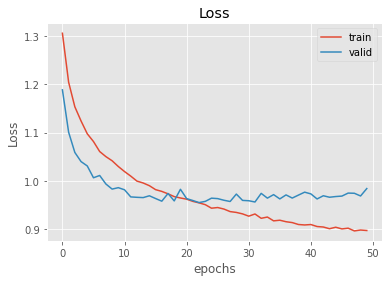

In [59]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show();

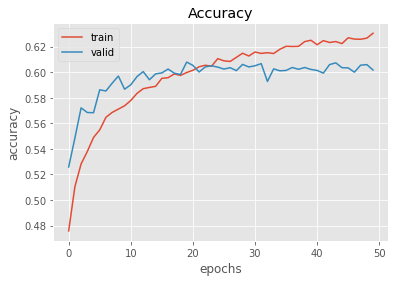

In [60]:
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()
plt.show();